**This problem set is due Wednesday, September 24, 2025 at 11:59 pm. Please plan ahead and submit your work on time.**

## Problem Set 02: Informed Search and Complexity of Uninformed Search

In this problem set you will implement informed search algorithms.

0. [Credit for Contributors (required)](#contributors)

1. [Informed Search on a Weighted Graph (40 pts)](#search_weighted_graph)
    1. [Create the Romania graph (2 points)](#romania_graph)
    2. [Complete the `GraphSearchProblem` class (3 points)](#graph_search_problem)
    3. [Best-First Search](#bfs)
    4. [Uniform Cost Search (10 points)](#ucs)
    5. [Define the `eucl_distance` function (3 points)](#eucl_distance)
    6. [Define the `eucl_distance` heuristic (2 points)](#eucl_heuristic)
    7. [Greedy Best-First Search (10 points)](#greedy_search)
    8. [A\* Search (10 points)](#astar)
    <br>
    <br>
              
2. [Path Planning on a Grid (30 pts)](#grid_search)
    1. [Complete the code for `grid_to_graph` (15 points)](#grid_to_graph)
    2. [Complete the code for `eucl_dist_cell` below. (5 points)](#eucl_dist_cell)
    3. [A\* on a grid (5 points)](#Astar_grid)
    4. [Greedy best-first search compared to A\* (5 points)](#greedy_worse_paths)
    <br>
    <br>

3. [Path Planning with the RRT (30 pts + 20 bonus)](#problem3)
    1. [Collision Testing (2 points)](#collision_testing)
    2. [Nearest Neighbors (3 points)](#nearest_neigbour)
    3. [Extending the Tree (5 points)](#extending_graph)
    4. [RRT Algorithm](#rrt)
    5. [Test your code on simple environment (10 points)](#simple_env_code)
    6. [Test your code on given environments (10 points)](#bugtrap_env_code)
    7. [Test your code on harder and random environments (Bonus +20 points)](#hard_env_code)
    <br>
    <br>

4. [How long did the pset take? (Bonus +5 points)](#pset)

     
**100 points + 25 bonus** total for Problem Set 2


Import the modules and classes needed for this problem set.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Modules
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
import yaml

from principles_of_autonomy.grader import Grader
from principles_of_autonomy.notebook_tests.pset_2 import TestPSet2

# Classes
from grid import Grid
from graph import Graph, Edge
from search_classes import SearchNode, Path
from utils import *
import functools
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly

## <a name="contributors"></a> 0. Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

No other contributors

## <a name="search_weighted_graph"></a> 1. Informed Search on a Weighted Graph

In this section you will code informed search algorithms that operate on a weighted graph.
We have provided code for creating a weighted graph (class `Graph` in `graph.py` -- you may want to look at the code).

The following example shows how to use the Graph class. (You may see a red warning box the first time after executing the following code, don't worry)

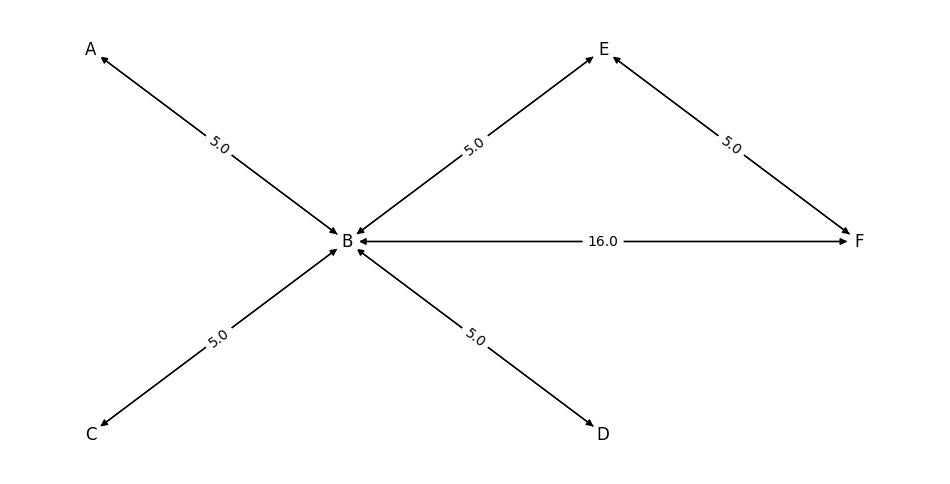

In [2]:
# Create graph
example_graph = Graph()

# Add graph edges
example_graph.add_edge("A", "B", weight=5.0)
example_graph.add_edge("B", "C", weight=5.0)
example_graph.add_edge("B", "D", weight=5.0)
example_graph.add_edge("B", "E", weight=5.0)
example_graph.add_edge("E", "F", weight=5.0)
example_graph.add_edge("B", "F", weight=16.0)

# Node locations (for visual representation)
example_node_locations = dict(A= (0,3), B= (4,0),
                              C= (0, -3), D= (8, -3),
                              E= (8, 3), F= (12, 0))
# Set the visual x,y position of the nodes
example_graph.set_node_positions(example_node_locations)

# Draw the graph
example_graph.draw()

### <a name="romania_graph"></a>1A. Create the Romania graph (2 points)

You will now be creating the graph of the Romania cities that is discussed in the AIMA book.
We give you the connections between the cities (`romania_connections`) and the x,y position of each citiy (`romania_locations`).

You graph should look like the following:

<img src=romania.png>

<div class="alert alert-info">
Create the graph in the variable `romania_graph`
</div>

In [3]:
# (don't modify this cell -- it will be overwritten by our test grading code)
# Distances between Romania's cities
# Example: The distance between C and R (or R and C) is romania_connections['C']['R'] = 146
romania_connections = dict(
    A=dict(Z=75, S=140, T=118),
    B=dict(U=85, P=101, G=90, F=211),
    C=dict(D=120, R=146, P=138),
    D=dict(M=75),
    E=dict(H=86),
    F=dict(S=99),
    H=dict(U=98),
    I=dict(V=92, N=87),
    L=dict(T=111, M=70),
    O=dict(Z=71, S=151),
    P=dict(R=97),
    R=dict(S=80),
    U=dict(V=142))

# x,y positions of Romania's cities
romania_locations = dict(
    A=( 91, 492),    B=(400, 327),    C=(253, 288),   D=(165, 299),
    E=(562, 293),    F=(305, 449),    G=(375, 270),   H=(534, 350),
    I=(473, 506),    L=(165, 379),    M=(168, 339),   N=(406, 537),
    O=(131, 571),    P=(320, 368),    R=(233, 410),   S=(207, 457),
    T=( 94, 410),    U=(456, 350),    V=(509, 444),   Z=(108, 531))

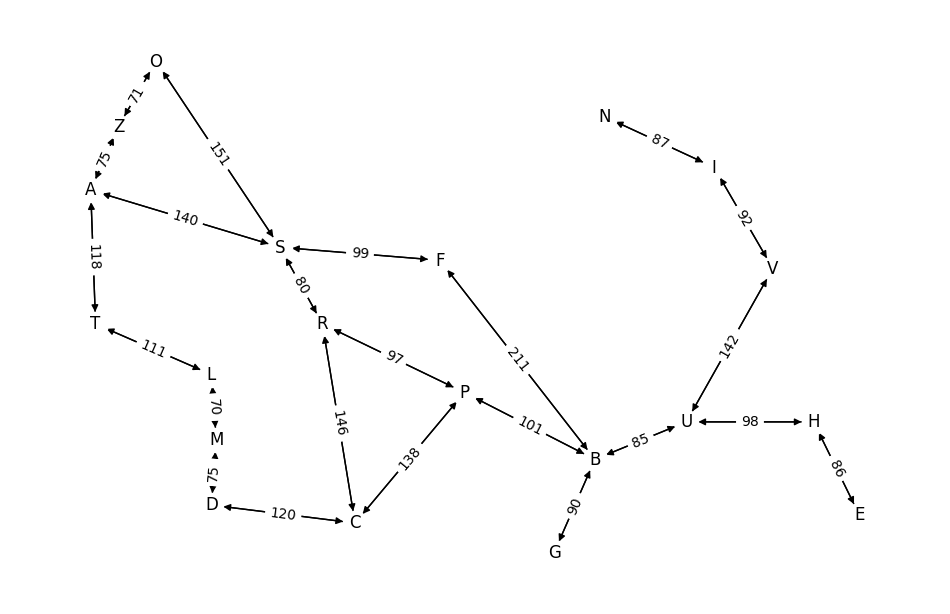

In [4]:
# Write the code to generate the romania_graph in this cell
# Save the graph in the romania_graph variable

romania_graph = Graph()
## Complete the code to generate the graph below...
for node1, node2_dict in romania_connections.items():
    for node2, distance in node2_dict.items():
        romania_graph.add_edge(node1, node2, distance)

# Add the locations
romania_graph.set_node_positions(romania_locations)

# Let's draw the graph you have generated now.
romania_graph.draw()

In [5]:
"""Check that the romania graph is correct"""
Grader.run_single_test_inline(TestPSet2, "test_01_romania_graph", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### <a name="graph_search_problem"></a>1B. Complete the `GraphSearchProblem` class (3 points)

In order to implement any of our search algorithms, we will need to define the `GraphSearchProblem` class that we'll use in the rest of this problem set.

Complete the function `expand_node(search_node)`.
This function should return a list of SearchNodes expanded from a graph SearchNode such that:

- The parent of the new search nodes is `search_node`
- The state of the new search nodes is the corresponding state according to the graph
- The cost of the new search nodes is the accumulated cost so far until `search_node` plus the cost from the state of the `search_node` to the new search node.

**Example:**
 One of the returned SearchNodes of `SearchNode("R", cost=12)` would be `SearchNode("S",parent_node=<node instance with state="R">,cost=12 + 80)`
 
<div class="alert alert-warning">
 **NOTE:** You may want to look at the definition of `SearchNode` in `search_classes.py`. Note that the `SearchNode` definition that we use in this ProblemSet is a little more complicated than the one used in ProblemSet01.
</div> 

<div class="alert alert-warning"> 
 You will also want to look at the `graph.py` file. In particular, note that the function `Graph.node_edges(node)` will give you all the outgoing Edges of a node in the graph. Also, each Edge has properties such as: source (the starting node), target (the end node) and weight (cost) of the edge.
</div>

<div class="alert alert-info">
Fill the code below.
</div>

In [6]:
# Complete the definition of expand_node below
class GraphSearchProblem(object):
    def __init__(self, graph, start, goal):
        self.graph = graph
        self.start = start
        self.goal = goal
    def test_goal(self, state):
        return self.goal == state
    def expand_node(self, search_node):
        """Return a list of SearchNodes, having the correct state, parent and updated cost."""
        edges = self.graph.node_edges(search_node.state) # edges is a set of Edge objects
        expanded_sn = [SearchNode(state=edge.target, parent_node=search_node, cost=search_node.cost+edge.weight) for edge in edges]   
        return expanded_sn

In [7]:
"""Check that GraphSearchProblem is implemented correctly"""
Grader.run_single_test_inline(TestPSet2, "test_02_graph_search_problem", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### <a name="bfs"></a>1C. Best-First Search

Next you will implement a search algorithm that we're going to call a Best-First Search algorithm with an expanded list. This is not exactly the same as the Greedy Best-First Search algorithm we saw in class. We're going to walk you through how to use the same Best-First Search algorithm for all the informed search strategies. 

Complete the code for `best_first_search(problem, f)` that takes a problem (such as `GraphSearchProblem` and a function `f(SearchNode)` and that returns a tuple of the following (in this order):

1. The best path from `problem.start` to `problem.goal` (according to the minimum `f`). Return the path as a `Path` class (see `search_classes.py`). (Note: This is very simple. You only need to return `Path(goal_node)` if `problem.test_goal(goal_node.state) == True`)
2. The number of expanded nodes (the size of the expanded list).
3. The maximum size that the queue reaches.

Note: consider that the signature of `f` is `f(SearchNode) -> value`. That is, `f` takes a SearchNode and returns a number.

**Hints regarding the PriorityQueue and the SearchNode classes:**

- Notice that when we create the PriorityQueue, we give it a parameter `f=f`. The PriorityQueue internally uses `f` to refer to whatever function is being used to prioritize the values. That parameter name is a little bit unfortunate, given that we will have an `h` function for Greedy Best-first search, a `g` function for Uniform Cost Search and an `f=g+h` function for A*. But that's why the initialisation of the PriorityQueue for Greedy Best-First search has an argument `f=f`. 
- The PriorityQueue will order the elements by the **min** value of `f` of each element.
- Whenever you do `q.pop()`, you get the element with the lowest f. Also, that element is removed from the queue at the same time.
- You can test whether something was already in the queue with the statement: `element in q`. Where `element` is whatever you want to test if it was in the queue.
- To test whether `element` is in the queue, the PriorityQueue iterates through all its elements and returns `True` if there is one element (`elementInQ`) for which `element == elementInQ` returns `True`.
- The `SearchNode` class that we are giving you is defined so that `search_node1 == search_node2` returns `True` if both `search_node1` and `search_node2` have the same state, **even if both have different parents, or different costs!**
- Because of this, you can use `search_node in q` to test if `q` contains a **different search node** (with possible different parent or cost) that has the same state than `search_node`.
- If that is the case, you can retrieve that previous search node that was in q, `previous_search_node`, with the same state as `search_node` by doing:

```python
previous_search_node = q[search_node]
```

- You could now compare any aspects of `previous_search_node` and `search_node` (you know they both have the same state, but the other properties could be different)
- Finally, you can delete that previous search node that was in the queue, and replace it by the search node. The position in the queue will be determined automatically by the PriorityQueue's `f` function, which we have set to be `h`. 

```python
# BEFORE: previous_search_node is in q and has state s
del q[previous_search_node]
q.append(search_node)
# AFTER: previous_search_node is no longer in q
# search_node is now in q and has state s
# the actual position of search_node in the q, will
# most likely be different from whatever that of previous_search_node was
```

- You will probably have to do this at some point. (If there's already a path to some state A, and you find a better path to state A, you want to delete that worse path from the Q and add the better path).


<div class="alert alert-info">
Complete the code for `best_first_search` below.
</div>

In [8]:
# We provide stub code for the best_first_search function that you must fill.
# The pseudo-code of the Search algorithm in the lecture slides may be useful here. 
def best_first_search(problem, f):
    """Returns a solution path."""
    q = PriorityQueue(f=f)
    q.append(SearchNode(problem.start))
    expanded = set([problem.start])
    max_q = 1
    path = list()
    while q:
        current = q.pop()
        
        # print(f"current node: {current}")
        if problem.test_goal(current.state):
            print(Path(current), len(expanded), max_q)
            return Path(current), len(expanded), max_q

        # If not done, expand the nodes and add them to the queue
        expand = problem.expand_node(current)
        for node in expand:
            if node not in expanded and node not in q:
                # print(f"new node being added to q: {node}")
                q.append(node)
            elif node in q:
                if node.cost < q[node].cost:
                    # print(f"updating cost for {q[node]} from {q[node].cost} to {node.cost}")
                    del q[node]
                    q.append(node)
        max_q = max(max_q, len(q))
        expanded.add(current)

    
    # If we get to here, no solution has been found.
    return None, len(expanded), max_q

### <a name="ucs"></a>1D. Uniform Cost Search (10 points)

That function by itself doesn't decide which search strategy to use. Please implement the function `uniform_cost_search(problem)` that uses the `best_first_search` code you defined earlier together with some definition of a function `f(SearchNode) -> value` that you'll pass to `best_first_search`.
Remember that Uniform Cost Search expand nodes in increasing order of cost. It will be useful to look at the definition of `SearchNode` (in `search_classes.py`), to see what information you can use.

<div class="alert alert-info">
Complete the code for `uniform_cost_search` below.
</div>

In [9]:
def uniform_cost_search(problem):
    def f(searchnode: SearchNode):
        return searchnode.cost + (0 if searchnode.parent == None else searchnode.parent.cost)

    return best_first_search(problem, f)

Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 15 4
UniformCostSearch Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 15. Max size of the queue: 4


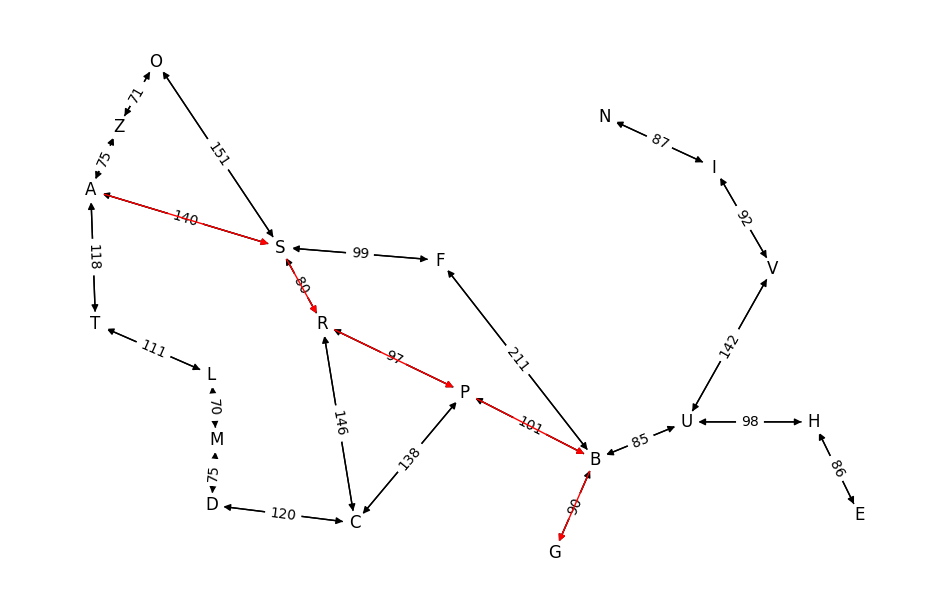

In [10]:
"""Try your implementation of Uniform Cost Search with this code"""

romania_problem = GraphSearchProblem(romania_graph, "A","G")
path, expanded, maxq = uniform_cost_search(romania_problem)
print("UniformCostSearch Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(path, expanded, maxq))

# Draw solution
if path:
    romania_graph.draw(highlight_edges=list(path.edges()))

In [11]:
"""Test uniform cost search."""
Grader.run_single_test_inline(TestPSet2, "test_03_uniform_cost_search", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 15 4


### Heuristics

In order to implement greedy search and A*, we first need to define the heuristic we want to use. Remember that the heuristic is an estimate of the distance from a given state to the goal.

We say that the heuristic is **admissible** if it is optimistic (it never over estimates the distance).

### <a name="eucl_distance"></a>1E. Euclidean distance (3 points)

Given that we know the `(x,y)` position of the cities of Romania (`romania_locations`), we'll use the straight line distance between cities as our heuristic.

Implement the `euclidean_distance(a,b)` function that returns the straight line distance between a and b. Consider that a and b are given as 2D tuples (e.g. `a=(0,0)`, `b=(3,4)`, then `euclidean_distance(a,b)=5`).

$distance = \sqrt{(a_x-b_x)^2 + (a_y - b_y)^2}$

<div class="alert alert-info">
Complete the code for `eucl_distance` below.
</div>


In [12]:
def eucl_dist(a, b):
    """Returns the euclidean distance between a and b."""
    return np.sqrt(sum([(a[i]-b[i])**2 for i in range(len(a))]))

In [13]:
"""Test euclidean distance code."""
Grader.run_single_test_inline(TestPSet2, "test_04_euclid_distance", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### <a name="eucl_heuristic"></a> 1F. Euclidean distance as a heuristic  (2 points)

Now let's define a specific euclidean distance heuristic from any SearchNode to the "G" state.
You will probably want to use the `romania_locations` dictionary.

**Example:** `h_to_G(SearchNode("A"))` should return about `360.4719`

<a name="h_to_g"></a>
<div class="alert alert-info">
Complete the code for `h_to_G` below.
</div>

In [14]:
goal_state = "G"
def h_to_G(search_node):
    return(eucl_dist(romania_locations[search_node.state], romania_locations[goal_state]))

In [15]:
"""Test h_to_G."""
Grader.run_single_test_inline(TestPSet2, "test_05_euclid_heuristic", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### <a name="greedy_search"></a>1G. Greedy Best-First Search (10 points)

Now let us use this heuristic function to implement `greedy_search(problem,h)`. Assume that `h(SearchNode)` is a function that returns the heuristic of a search node with respect to some goal.

Your solution should call your `best_first_search` function.

<div class="alert alert-info">
Complete the code for `greedy_search` below.
</div>

In [16]:
def greedy_search(problem, h):
    return best_first_search(problem, h)

Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G'] 5 7
Greedy Path:
 Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G']. 
Nodes expanded: 5. Max size of the queue: 7


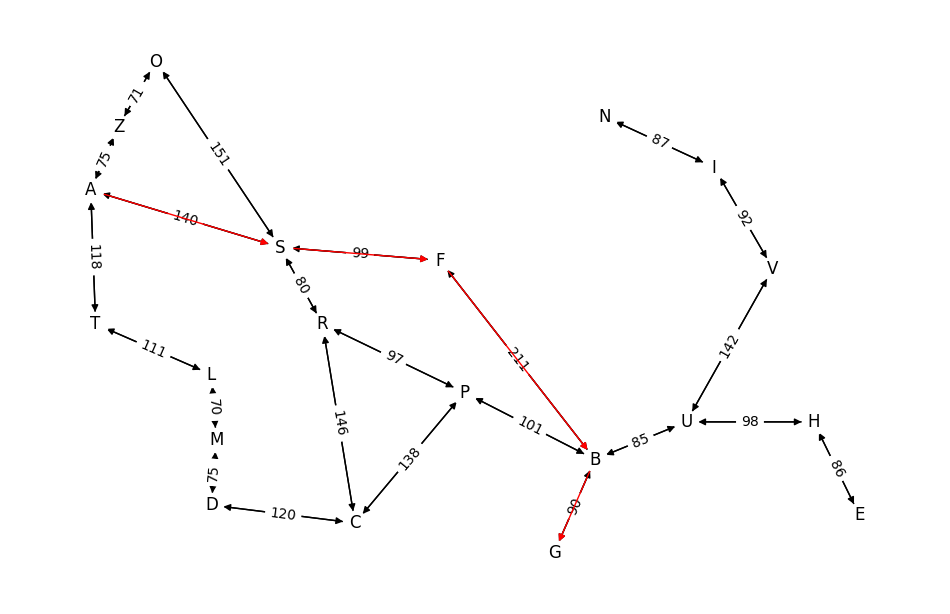

In [17]:
"""Try your greedy search implementation with this code"""
start_state = "A"
goal_state = "G"
romania_problem = GraphSearchProblem(romania_graph, start_state,goal_state)
path, expanded, maxq = greedy_search(romania_problem, h_to_G)
print("Greedy Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(path, expanded, maxq))

# Draw solution
if path:
    romania_graph.draw(highlight_edges=list(path.edges()))

In [18]:
"""Test A* search."""
Grader.run_single_test_inline(TestPSet2, "test_06_greedy", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G'] 5 7


### <a name="astar"></a>1H. A* Search (10 points)

Now let us implement `astar_search(problem,h)`. Assume that `h(SearchNode)` is a function that returns the heuristic of a search node with respect to some goal.

Again, you should be using your `best_first_search` function.

Remember that for A*, $f(n) = cost(n) + h(n)$.

<div class="alert alert-info">
Complete the code for `astar_search` below.
</div>

In [19]:
def astar_search(problem, h):
    def f(searchnode):
        return searchnode.cost + h(searchnode)
    return best_first_search(problem, f)

Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 11 6
A* Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 11. Max size of the queue: 6


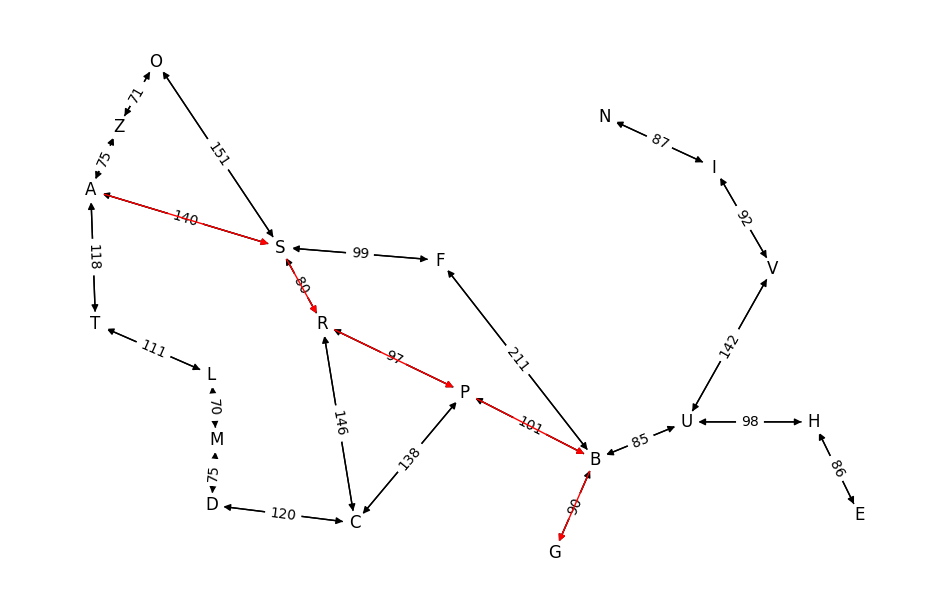

In [20]:
"""Try your A* search implementation with this code"""
start_state = "A"
goal_state = "G"
romania_problem = GraphSearchProblem(romania_graph, start_state,goal_state)
path, expanded, maxq = astar_search(romania_problem, h_to_G)
print("A* Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(path, expanded, maxq))

# Draw solution
if path:
    romania_graph.draw(highlight_edges=list(path.edges()))

In [21]:
"""Test A* search."""
Grader.run_single_test_inline(TestPSet2, "test_07_astar", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 11 6


In [22]:
"""Compare the results of uniform cost search, greedy search and A*"""

problem = GraphSearchProblem(romania_graph, "A", "G")

sol, expanded, maxq = uniform_cost_search(problem)
print("UCS Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(sol, expanded, maxq))

sol, expanded, maxq = greedy_search(problem, h_to_G)
print("Greedy Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(sol, expanded, maxq))

sol, expanded, maxq = astar_search(problem, h_to_G)
print("A* Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(sol, expanded, maxq))


Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 15 4
UCS Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 15. Max size of the queue: 4
Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G'] 5 7
Greedy Path:
 Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G']. 
Nodes expanded: 5. Max size of the queue: 7
Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 11 6
A* Path:
 Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G']. 
Nodes expanded: 11. Max size of the queue: 6


## <a name="grid_search"></a>2. Path Planning on a Grid

In this section you'll learn how to apply the search tools for path planning on a grid.

<img src="grid_path.png"/>

### Getting familiarized with the Grid class

We have provided a `Grid` class.
The following code shows how to use the Grid class. The `Grid` class is defined in `grid.py`.

Note that the origin of the grid `(0,0)` corresponds to the lower left cell, and that `x` increases to the right, and `y` increases going up.

Num cols, num rows:  (6, 6)
(2,1) is obstacle? True
(0,0) is obstacle? False
Cell dimensions:  (1.0, 1.0)


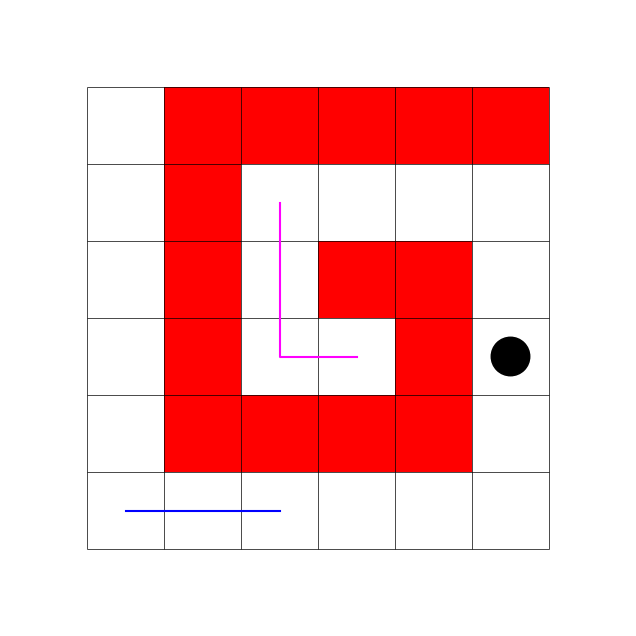

In [23]:
# Create grid from text.
# 1: obstacle, 0: free region
# Modify the text to create your own grid
# Ensure that the number of columns is constant!
grid_str = """0 1 1 1 1 1
              0 1 0 0 0 0
              0 1 0 1 1 0
              0 1 0 0 1 0
              0 1 1 1 1 0
              0 0 0 0 0 0"""
test_grid = Grid.create_from_str(grid_str)

# Access the grid elements
print("Num cols, num rows: ", test_grid.size)
print("(2,1) is obstacle?", test_grid.grid_array[2,1] > 0)
print("(0,0) is obstacle?", test_grid.grid_array[0,0] > 0)
print("Cell dimensions: ", test_grid.cell_dimensions)

# Drawing functions
# Draw the grid
axes = test_grid.draw()
# Draw a circle in cell (5,2) [col 5, row 2]
test_grid.draw_cell_circle(axes, (5,2),color='black')
# You can draw some paths, too
test_grid.draw_path(axes, [(0,0), (1,0), (2,0)], color='blue')
test_grid.draw_path(axes, [(2,4), (2,3), (2,2), (3,2)], color='magenta')

### <a name="grid_to_graph"></a>2A. Creating a graph from a grid (15 points)

You will code the function `grid_to_graph(grid, diagonal_moves)` that creates a `Graph` class like the one we have been using in the rest of the exercise from a `Grid`.

Keep the following things in mind when coding this function:

- The number of nodes in the graph needs to be equal to the number of obstacle free cells in the grid. (i.e. don't create nodes for cells that are blocked)
- The nodes should be designed by a tuple of their (col, row) position, being the lower left cell the (0,0) node, and the upper right cell the (num_cols-1, num_rows-1) cell. That, is, to create nodes (2,3) and (2,4) and add an edge of length 5.0 between them, you should do: `graph.add_edge((2,3),(2,4), 5.0)`. If cell `(2,3)` is obstacle free, then `"(2,3) in graph"` should return `True`.
- Use the right length for the edges. `grid.cell_dimensions` gives you the `(width, height)` of each cell. Keep in mind that diagonal moves are longer than straight moves.
- Note that `graph.add_edge((2,3),(2,4), 5.0)` creates an edge from (2,3) to (2,4) but ALSO, from (2,4) to (2,3). It doesn't matter the order that you choose, and it's ok if you do it multiple times (the graph will only keep one edge).
- A grid cell can connect to any other adjacent one if both cells are obstacle free.
- Only connect cells diagonally if the argument `diagonal_moves = True`.


<div class="alert alert-info">
Complete the code for `grid_to_graph` below.
</div>

In [99]:
def grid_to_graph(grid, diagonal_moves=True):
    graph = Graph()
    obstacles = grid.get_obstacles()
    grid_list = grid.export_to_dict()['grid']
    
    cells = set([(r,c) for r in range(len(grid_list)) for c in range(len(grid_list)) if (r,c) not in obstacles])
    edges = set()

    diagonal = [(i, j) for i in range(-1,2) for j in range(-1,2)]
    no_diagonal = [(0,1), (0,-1), (-1,0), (1,0)]
    diff = diagonal if diagonal_moves else no_diagonal

    for cell in cells:
        graph.add_node(cell)
        for (i, j) in diff:
            adjacent = (cell[0]+i, cell[1]+j)
            dist = eucl_dist(grid.cell_xy(cell[0], cell[1]), grid.cell_xy(adjacent[0], adjacent[1]))
            if adjacent in cells and adjacent != cell:
                graph.add_edge(cell, adjacent, dist)
    return graph
    
    

In [100]:
"""Test grid to graph function. Don't modify the grid test string or the tests will fail."""
Grader.run_single_test_inline(TestPSet2, "test_08_grid_to_graph", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### <a name="eucl_dist_cell"></a>2B. Euclidian distance between grid cells (5 points)

Let's start defining the function `eucl_dist_cell(graph_node, goal_cell, cell_dimensions)`.
This function represents the euclidean distance between two cells (taking into account the width and the height of each cell).

As an example, the result of `eucl_dist_cell(SearchNode((2,3)), (5,5), (1,2))` should be `5.0`. This represents the distance between cell `(2,3)` and cell `(5,5)` if the width of each cell is `1` and the height of each cell is `2`.

<div class="alert alert-info">
Complete the code for `eucl_dist_cell` below.
</div>


In [105]:
def eucl_dist_cell(graph_node, goal_cell, cell_dimensions):
    start_cell = graph_node.state
    w,h = cell_dimensions
    distance = eucl_dist(
        (start_cell[0]*w, start_cell[1]*h), 
        (goal_cell[0]*w, goal_cell[1]*h)
    )
    return distance

In [106]:
"""Test the eucl_dist_cell function"""
Grader.run_single_test_inline(TestPSet2, "test_09_eucl_dist_cell", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### <a name="Astar_grid"></a> 2C. A* on a grid (5 points)

Now let's use the your definition of `eucl_dist_cell` to create the heuristic function and use A\* to find a path in the grid.

Run the code below. You should see how A\* finds the path in the grid. Try changing the `diagonal_moves` option in the `grid_to_graph` function to see how that affect the paths that you get.

Path of length 9, cost: 9.657: [(2, 1), (1, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 3)] 14 4
A* Path:
 Path of length 9, cost: 9.657: [(2, 1), (1, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 3)]. 
Nodes expanded: 14. Max size of the queue: 4


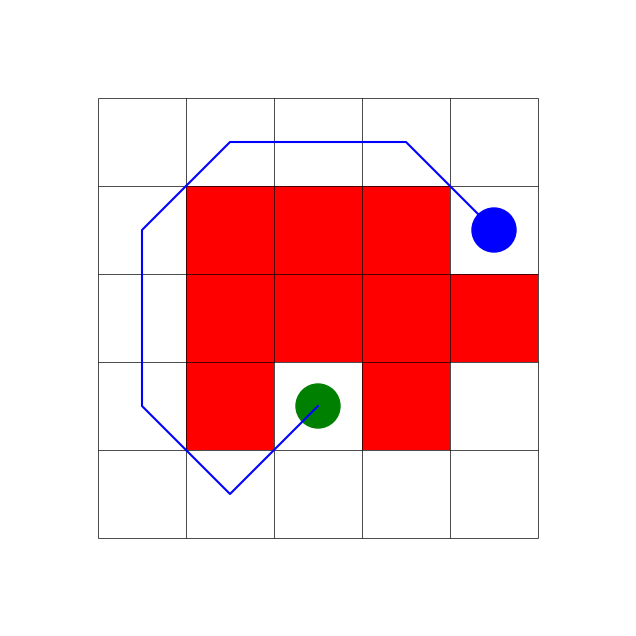

In [107]:
"""Try your A* implementation with this code."""

start = (2,1)
goal = (4,3)

grid_str = """0 0 0 0 0
              0 1 1 1 0
              0 1 1 1 1
              0 1 0 1 0
              0 0 0 0 0"""
grid = Grid.create_from_str(grid_str)

# Define the heuristic function that returns the heuristic distance from any search node to
# the goal cell
h = lambda n: eucl_dist_cell(n, goal, grid.cell_dimensions)

graph = grid_to_graph(grid, diagonal_moves=True)

# Now that our grid is a graph, we can create a GraphSearchProblem just as we did in 
# Part 1 

problem = GraphSearchProblem(graph, start,goal)

solution_astar, expanded, maxq = astar_search(problem, h)
print("A* Path:\n %s. \nNodes expanded: %d. Max size of the queue: %d" %(solution_astar, expanded, maxq))

# Plot
axes = grid.draw()
grid.draw_path(axes,solution_astar.path, color='b')
grid.draw_cell_circle(axes, start, color='g')
grid.draw_cell_circle(axes, goal, color='b')

Let's test that your A\* implementation is correct.

In [108]:
"""Test A* in a grid. Don't modify the grid test string or the tests will fail."""
Grader.run_single_test_inline(TestPSet2, "test_10_astar_grid", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


Path of length 9, cost: 9.657: [(2, 1), (1, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 3)] 14 4


### <a name="greedy_worse_paths"></a>2D. Greedy best-first search compared to A\* (5 points)

Try running A\* and Greedy Best-First Search in the graph below.

<div class="alert alert-info">
Find start and goal locations for which the solution returned by Greedy Search is much worse than A*.
</div>

In [121]:
# Modify the start and goal locations
# Example (not a good choice)
# Uncomment to test
# start, goal = (0,0), (14,2)
start, goal = (0,0), (35,19)

Path of length 36, cost: 42.870: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (9, 7), (10, 8), (11, 8), (12, 9), (13, 9), (14, 9), (15, 10), (16, 10), (17, 10), (18, 11), (19, 11), (20, 12), (21, 12), (22, 12), (23, 12), (24, 12), (25, 12), (26, 13), (27, 13), (28, 13), (29, 13), (30, 14), (31, 15), (32, 16), (33, 17), (34, 18), (35, 19)] 264 59
Path of length 53, cost: 66.912: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 19), (22, 20), (23, 20), (24, 21), (25, 20), (26, 21), (26, 22), (26, 23), (27, 24), (28, 24), (29, 25), (30, 26), (30, 27), (30, 28), (31, 29), (32, 28), (33, 27), (34, 28), (35, 29), (36, 29), (37, 28), (37, 27), (37, 26), (36, 25), (35, 25), (34, 25), (33, 24), (34, 23), (35, 22), (35, 21), (35, 20), (35, 19)] 67 107


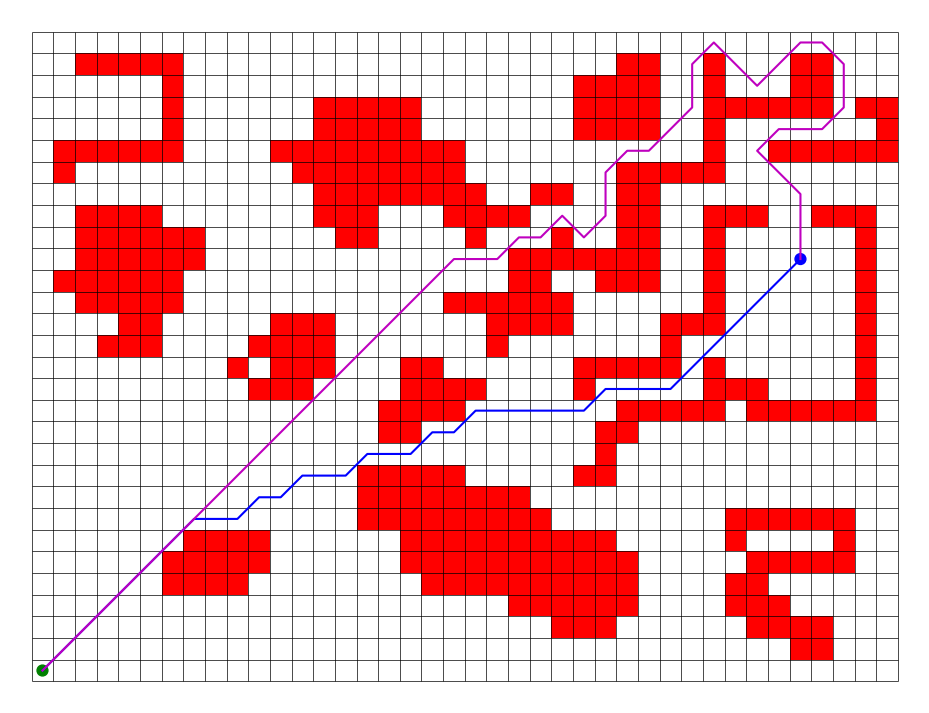

In [122]:
"""Try your chosen start and goal locations with this code."""
grid = Grid.create_from_file("hard_grid.txt")
h = lambda n: eucl_dist_cell(n, goal, grid.cell_dimensions)
graph = grid_to_graph(grid, diagonal_moves=True)
problem = GraphSearchProblem(graph, start,goal)
solution_astar, expanded, maxq = astar_search(problem, h)
solution_greedy, expanded, maxq = greedy_search(problem, h)

# Draw
axes = grid.draw()
grid.draw_path(axes,solution_astar.path, color='b')
grid.draw_path(axes,solution_greedy.path, color='m')
grid.draw_cell_circle(axes, start, color='g')
grid.draw_cell_circle(axes, goal, color='b')

#### <a name="greedy_explanation"></a>Explain why the path returned by Greedy search is worse

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Greedy only explores the locally best options, while A* considers pasts costs. This means Greedy has a tendency to get stuck in searching a path that may seem optimal at the start but often is not the shortest path. Like described in lecture, this can turn into a "poorly-guided DFS".

## <a name="problem3"></a> 3. RRT Path Planning

We saw in class that in some cases, it is quite hard to convert a configuration space to a grid, and we had to construct the graph as part of the planning process. In this problem we will examine one algorithm for doing just that. We will ask you will implement the Rapidly-Exploring Random Tree (RRT) algorithm to help a robot navigate from its starting position to the desired end region in an environment full of obstacles. The three environments that we will use in this question are shown here. 

<img src='rrt_examples.png'/>

Let us assume that we have a class `Node` that contains a possible state of our robot. We are going to assume a 2D disc robot, so our configuration space can be 2 dimensional as well.

In [123]:
class Node:
    def __init__(self, point: tuple, children=None, parent=None):
        assert len(point) == 2  # input point should be 2d tuple (x, y)
        assert isinstance(point, tuple)
        self.xy = np.array(point)
        self.parent = parent
        self.children = children if children else []
    
    @property
    def flat(self):
        yield self
        for c in self.children:
            for n in c.flat:
                yield n
    @property
    def point(self):
        return Point(self.xy)
    
    @property
    def ancestry(self):
        yield self
        if self.parent is not None:
            for a in self.parent.ancestry:
                yield a
        
    @property
    def path(self):
        path = list(self.ancestry)
        for n in reversed(path):
            yield tuple(n.xy)
    
    def __repr__(self):
        return "<Node xy: %s>" % (self.xy)

### <a name="collision_testing"></a> 3A. Collision Testing (2 points) ###
    
The first important test in the RRT is to see if a sampled state is in collision with the obstacles in the environment. Please implement a `collision_free` method that takes a `tuple (x, y)`, the radius of the robot and an `Environment env` object that stores the obstacles, and returns if the robot at xy is in collision with any of the obstacles in `env`. You may wish to look at the `environment.py` class to see how to access the obstacles. We have given you the first line to construct a point with a given radius. 

In [152]:
def collision_free(xy: tuple, radius: float, env: Environment):
    """
    The first important test in the RRT is to see if a sampled state 
    is in collision with the obstacles in the environment. Please 
    implement a collision_free method that takes a tuple (x, y), 
    the radius of the robot and an Environment env object that stores 
    the obstacles, and returns if the robot at xy is in collision with 
    any of the obstacles in env. You may wish to look at the 
    environment.py class to see how to access the obstacles. 
    We have given you the first line to construct a point with a given radius.
    """
    p = Point(xy).buffer(radius, resolution=3)
    collision_test_result = all(not p.intersects(obstacle) for obstacle in env.obstacles)
    return collision_test_result

In [153]:
Grader.run_single_test_inline(TestPSet2, "test_11_collision_testing", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.022s

OK


### <a name="nearest_neigbour"></a>3B. Nearest Neighbors (3 points) ### 


The next important step in the RRT is to find the nearest neighbour in the tree to a sampled point. Please implement a method `find_nearest_neighbor` that takes a `tuple (x,y)` and a list of nodes and returns the nearest neighbour from the list. 

In [158]:
def find_nearest_neighbor(xy: tuple, nodes: list[Node]):
    """
    The next important step in the RRT is to find the nearest 
    neighbour in the tree to a sampled point. Please 
    implement a method find_nearest_neighbor that takes a 
    tuple (x,y) and a list of nodes and returns the nearest 
    neighbour from the list.
    """
    nn = None
    min_dist = float('inf')
    for node in nodes:
        nx,ny = node.xy
        dist = eucl_dist(xy, (nx,ny))
        if dist < min_dist:
            min_dist = dist
            nn = node

    return nn

In [159]:
Grader.run_single_test_inline(TestPSet2, "test_12_nearest_neighbor", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


### <a name="extending_graph"></a>3C. Extending the Tree (5 points) ### 

Given a collision-free sample, and the nearest neighbour in the tree, we need to grow the tree towards the sample. 

Please implement a method `extend` that takes a `Node parent` that is already in the tree, a new sample `tuple (x, y)`, and a maximum distance `d`. The method should then consider the edge between `parent` and `xy`. If this edge is longer than `d`, `xy` should be scaled back to be at most `d` away from `parent`. If this edge is in collision, `extend` should return None. Otherwise `extend` should return the new node at `xy` (which may have been scaled). 


In [195]:
def extend(parent, xy, radius, d, env):
    """
    Given a collision-free sample, and the nearest neighbour in the tree, 
    we need to grow the tree towards the sample.
    
    Please implement a method extend that takes a Node parent that is already 
    in the tree, a new sample tuple (x, y), and a maximum distance d. The 
    method should then consider the edge between parent and xy. If this edge 
    is longer than d, xy should be scaled back to be at most d away from parent. 
    If this edge is in collision, extend should return None. Otherwise extend 
    should return the new node at xy (which may have been scaled).
    """
    new_node = None 
    x, y = xy
    px, py = parent.xy
    dist = eucl_dist(xy, parent.xy)
    if dist > d:
        dx, dy = ((x-px) * d/dist, (y-py) * d/dist)
        scaled_back = (px + dx, py + dy)
        if all(not LineString([scaled_back, tuple(parent.xy)]).intersects(obstacle) for obstacle in env.obstacles):
            new_node = Node(scaled_back, parent=parent)
    
    return new_node

In [196]:
Grader.run_single_test_inline(TestPSet2, "test_13_extend", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


### 3D. The RRT algorithm ### 

Let us put all these pieces together, to implement the function `rrt` with the following signature:

```python
def rrt(bounds, environment, start_pose, radius, end_region)
```

where:
- `bounds=(minx, miny, maxx, maxy)` is a tuple that indicates the bounds of the environment (the region the robot can traverse). Example `bounds=(-5, -4, 15, 5)`.
- `environment` is an instance of the `Environment` class that describes the placement of the obstacles in the scene (see more examples below).
- `start_pose = (x,y)` is a tuple indicating the starting position of the robot. Example: `start_pose=(-4, -2)`.
- `radius` is the radius of the robot (used for collision checking). Example `radius=0.1`.
- `end_region` is a `shapely` `Polygon` that describes the region that the robot needs to reach. See examples below.

Your function should:

- return a list of tuples `(x, y)` describing the obstacle free path that takes the robot to the target region. Example of a valid returned path: `[(-4, -2), (-3.71, -1.97), (-3.41, -1.8865), (-3.50, -2.69)]`. Note that your rrt function should produce paths such that the straight line connecting any pair of consecutive points should be obstacle free (considering the obstacles and the size of the robot). In the given example, it should be possible to go from `(-4, -2)` to `(-3.71, -1.97)` in a straight line without colliding with anything.
- produce a plot showing the tree and the obstacle free path (such as the ones shown above)
- show the number of nodes in the tree, the number of nodes in the solution path and the path length (you could put this in the plot title, as in the examples above)


**You are required to submit this notebook with:**

1. The code function `rrt` as described above
2. The results (plots) of using your `rrt` function in the easy and bugtrap environments provided (see code stubs below).
3. The results of using your `rrt` function in a challenging (600 obstacles) environment that is provided.

See the provided example notebook [RRT Helpful Examples](RRT_Helpful_examples.ipynb) for examples on how to use the `Environment` class, the `shapely` library, and how to do some simple collision checking.


<div class="alert alert-info">
**NOTE:** You don't need to write all your code in this notebook if you don't want to. You could create your own `.py` files and then import them into this notebook. We do require that we are able to run the two environments that we provide and the two that you generate in this notebook and that the plots are embedded here.
</div>


<div class="alert alert-warning">
Please ensure that you submit your notebook with the cells already executed. That is, you should save the notebook when your code has been executed and the plots are visible. That way, we will be able to look at your solution initially without running your code first.
</div>



In [207]:
# Write your RRT code here (this cell and below)!
# Note that you can write your code in separate .py files
# and import them here later if you prefer

import time
from IPython.display import clear_output, display
# %load_ext line_profiler

def path_info(path):
    nnodes = len(path)
    length = sum(list(np.sum(map(lambda a:np.linalg.norm(np.array(a[0]) - np.array(a[1])) ,zip(path[:-1],path[1:])))))
    return nnodes, length

def sample_box(bounds):
    minx, miny, maxx, maxy = bounds
    r = np.random.uniform(low=0.0, high=1.0, size=2)
    return (minx + (maxx-minx)*r[0], miny + (maxy-miny)*r[1])

def rrt(bounds, environment, start_pose, radius, end_region):
    start_t = time.time()
    extend_length = 0.3
    root = Node(start_pose)
    
    ax = plot_environment(environment, bounds=bounds)
    minx, miny, maxx, maxy = bounds
    box = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])
    plot_poly(ax, box, 'white', alpha=1, zorder=-50)
    plot_poly(ax, end_region, 'green', alpha=0.5, zorder=10)
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
    
    plot_poly(ax, Point(start_pose).buffer(radius,resolution=3), 'red', alpha=1, zorder=25)
    
    f = plt.gcf()
    display(f)

    # TODO
    nodes = [root]

    N = 20000 # max iters
    solution_node = None
    
    for i in range(N):
        random_point = sample_box(bounds)
        nearest_node = find_nearest_neighbor(random_point, nodes)
        new_node = extend(nearest_node, random_point, radius, extend_length, environment)
        
        if new_node is not None:
            # Collision-free check
            if collision_free(new_node.xy, radius, environment):
                # Connect the new node to the tree
                nearest_node.children.append(new_node)
                nodes.append(new_node)
                
                # Visualize the new edge
                x_vals = [nearest_node.xy[0], new_node.xy[0]]
                y_vals = [nearest_node.xy[1], new_node.xy[1]]
                ax.plot(x_vals, y_vals, 'b-', alpha=0.3, linewidth=0.5)

                # Goal check
                robot_at_goal = Point(new_node.xy).buffer(radius, resolution=3)
                if end_region.contains(robot_at_goal):
                    solution_node = new_node
                    print(f"Solution found after {i+1} iterations!")
                    break
        
        # updat vis
        if i % 100 == 0:
            clear_output(wait=True)
            display(f)
    
    if solution_node is not None:
        # path = [tuple(point) for point in solution_node.path]
        # # current_node = solution_node
        # # while current_node is not None:
        # #     path.append(current_node.xy)
        # #     current_node = current_node.parent
        path = []
        current_node = solution_node
        while current_node is not None:
            path.append(tuple(current_node.xy))
            current_node = current_node.parent
        path.reverse()
        if len(path) > 0:
            path[0] = start_pose
        
        # Visualize soln
        for i in range(len(path) - 1):
            x_vals = [path[i][0], path[i+1][0]]
            y_vals = [path[i][1], path[i+1][1]]
            ax.plot(x_vals, y_vals, 'r-', linewidth=2, zorder=20)
        
        # Calculate path info
        nnodes_tree = len(nodes)
        nnodes_path, path_length = path_info(path)
        
        plt.title(f'RRT Path\nTree Nodes: {nnodes_tree}, Path Nodes: {nnodes_path}, Path Length: {path_length:.2f}')
        
        clear_output(wait=True)
        display(f)
        
        return path
    else:
        print(f"No path found within {N} iters")
        return None
        

### <a name="simple_env_code"></a> 3E. Test your code on the simple environment (10 points) ##

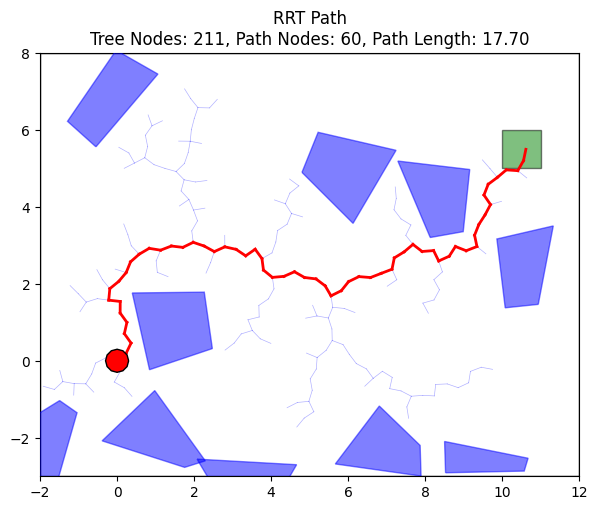

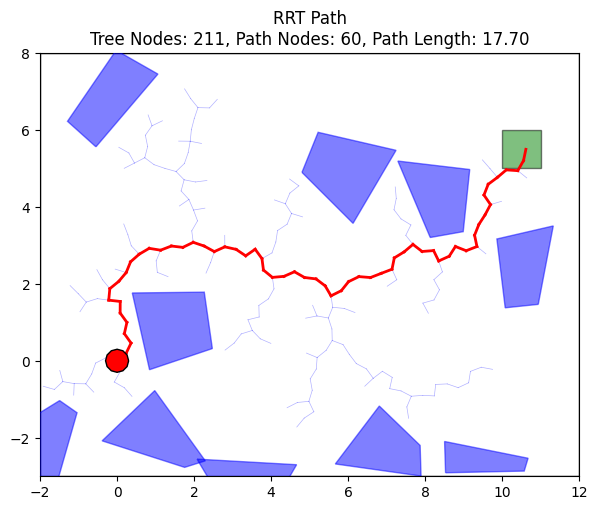

In [208]:
# Test your code in the simple environment
# don't modify this cell. It will be overwritten by the autograder.
# if you want to test things, please create additional cells at the end
environment_simple = Environment('simple.yaml')
radius_simple = 0.3
bounds_simple = (-2, -3, 12, 8)
start_simple = (0, 0)
goal_region_simple = Polygon([(10,5), (10,6), (11,6), (11,5)])
path_simple = rrt(bounds_simple, environment_simple, start_simple, radius_simple, goal_region_simple)

In [209]:
# This function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
Grader.run_single_test_inline(TestPSet2, "test_14_simple_environment", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### <a name="bugtrap_env_code"></a> 3F. Test your code on the bugtrap environment (10 points) ##

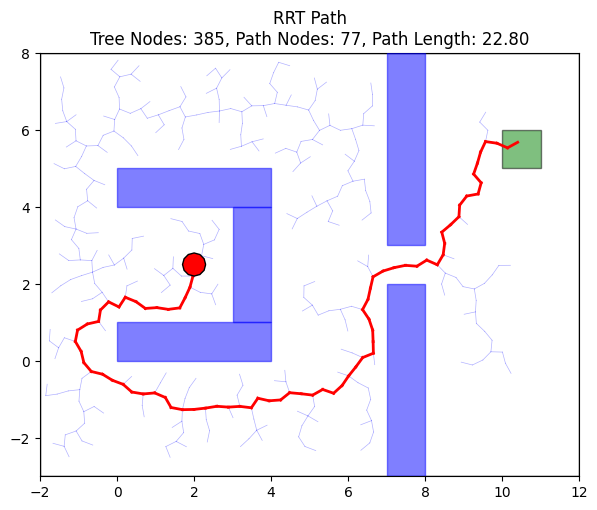

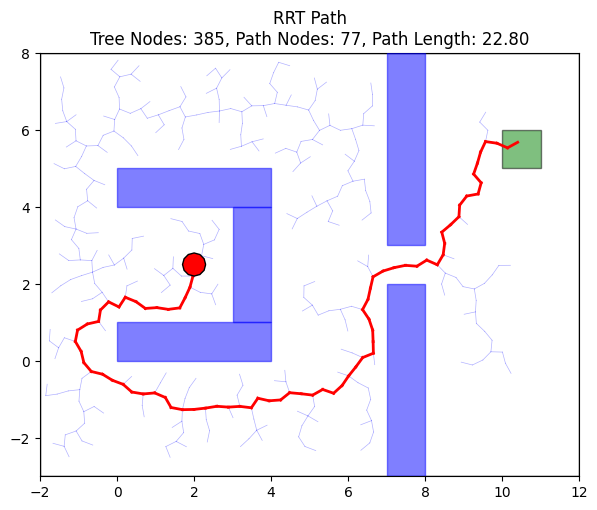

In [217]:
# Test your code in the bugtrap environment
# don't modify this cell. It will be overwritten by the autograder.
# if you want to test things, please create additional cells at the end
environment_bugtrap = Environment('bugtrap.yaml')
radius_bugtrap = 0.3
bounds_bugtrap = (-2, -3, 12, 8)
start_bugtrap = (2, 2.5)
goal_region_bugtrap = Polygon([(10,5), (10,6), (11,6), (11,5)])
path_bugtrap = rrt(bounds_bugtrap, environment_bugtrap, start_bugtrap, radius_bugtrap, goal_region_bugtrap)

In [218]:
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
Grader.run_single_test_inline(TestPSet2, "test_15_bugtrap_environment", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### <a name="hard_env_code"></a> 3G. Test your code on the harder environment that we have provided (Bonus 20 points)**

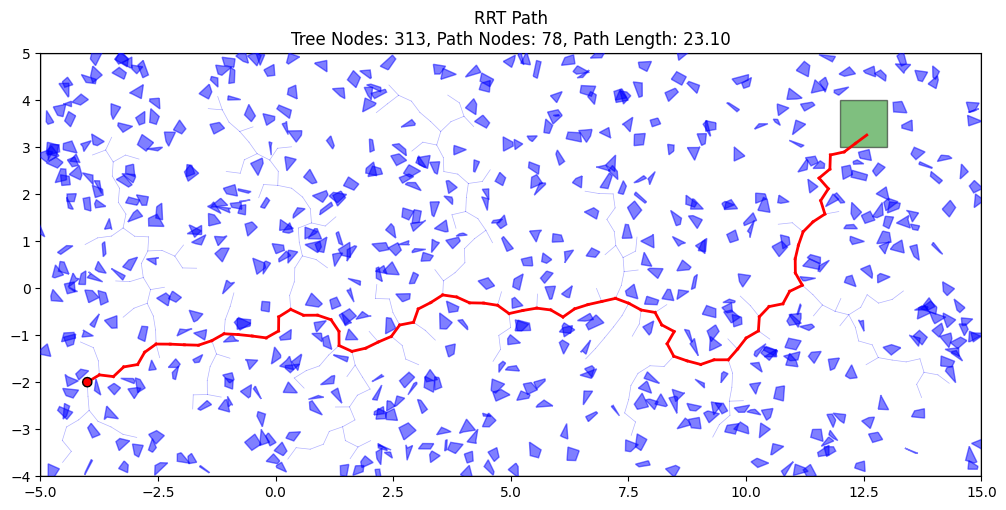

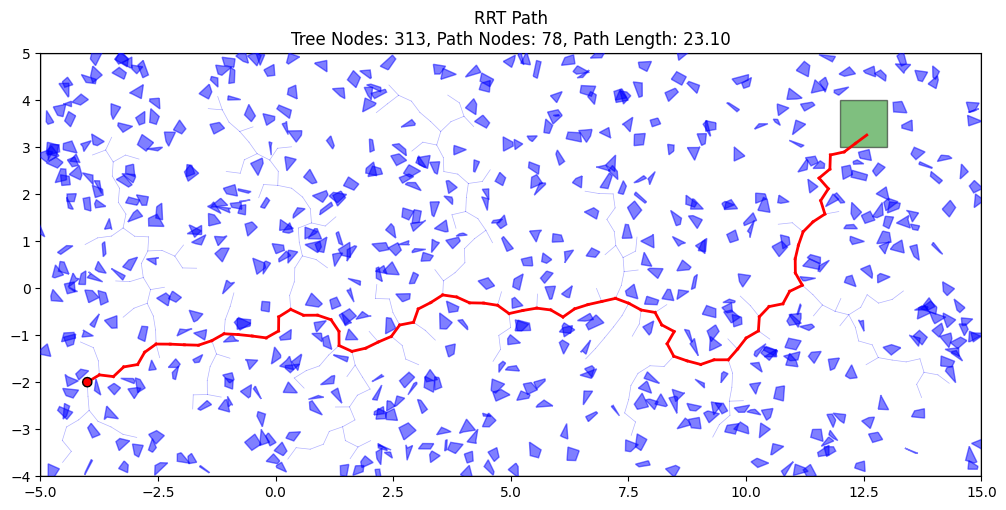

In [212]:
# Test your code in the challenging environment that you made
environment_challenging = Environment('challenging600.yaml')
start_challenging = (-4,-2)
radius_challenging = 0.1
goal_region_challenging = Polygon([(12,3), (12,4), (13,4),(13,3)])
bounds_challenging = (-5, -4, 15, 5)
path_challenging = rrt(bounds_challenging, environment_challenging, start_challenging, radius_challenging, goal_region_challenging)

In [213]:
Grader.run_single_test_inline(TestPSet2, "test_16_complex_environment", locals())

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### <a name="Time Spent"></a> 4. Time Spent on Pset (5 points)

Please use [this form](https://forms.gle/NZT3HPRpDLP3nTXB7) to tell us how long you spent on this pset. After you submit the form, the form will give you a confirmation word. Please enter that confirmation word below to get an extra 5 points. 

In [214]:
form_confirmation_word = "Bibimbap"

In [219]:
# Run all tests. Note that the total number of autograding points is 120 (25 are bonus)
Grader.grade_output([TestPSet2], [locals()], "results.json")
Grader.print_test_results("results.json")

# NOTE: This is not the last cell! See below for more information about the TA script!

Total score is 120/120.

Score for test_01_romania_graph (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 2/2.

Score for test_02_graph_search_problem (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 3/3.

Score for test_03_uniform_cost_search (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 10/10.
- Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 15 4


Score for test_04_euclid_distance (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 3/3.

Score for test_05_euclid_heuristic (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 2/2.

Score for test_06_greedy (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 10/10.
- Path of length 5, cost: 540.000: ['A', 'S', 'F', 'B', 'G'] 5 7


Score for test_07_astar (principles_of_autonomy.notebook_tests.pset_2.TestPSet2) is 10/10.
- Path of length 6, cost: 508.000: ['A', 'S', 'R', 'P', 'B', 'G'] 11 6


Score for test_08_grid_to_graph (principles_of_autonomy.notebook_tests

In [220]:
# The TAs have created a new utility function that will (1) automatically zip all required files and (2) extract your open-ended answers for
# easier grading. Please try running it before submitting (and try submitting the resulting zip file to Gradescope). If you run into issues,
# no worries - this will not affect your grade! This is only meant to make submission easier, and we would appreciate feedback or reports
# of errors on this PSET's submission form. Thanks!

# Make sure you save the notebook before running this cell so that the most updated version is zipped!
Grader.prepare_submission("ProblemSet02_InformedSearch_release")

Open-ended responses written to ProblemSet02_InformedSearch_release_responses_only.ipynb
Compressed files in folder to ../ps2/ps2.zip (submit this to Gradescope)


/usr/local/lib/python3.10/dist-packages/nbformat/__init__.py:132: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
